In [1]:
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor

import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.get_device_properties(0)

/home/deadscholar/miniconda3/envs/gluon/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_CudaDeviceProperties(name='NVIDIA RTX A5500 Laptop GPU', major=8, minor=6, total_memory=16383MB, multi_processor_count=58)

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [22]:
# Because the actions should be in [-1, +1] range, we do arctanh, model it, then tanh.
def data_preprocessor(x):
    return np.arctanh(0.995 * np.clip(x, -1.0, +1.0))

def data_un_preprocessor(x):
    return np.clip(np.tanh(x)/0.995, -1.0, +1.0)

In [4]:
env_names = ['hopper', 'halfcheetah', 'walker2d']
policy_names = ['random', 'medium-replay', 'medium', 'medium-expert']

dataset_dict = {}
rtg_dict = {}
for i, policy_name in enumerate(policy_names):
    for j, env_name in enumerate(env_names):
        name = '{e}-{p}-v2'.format(e=env_name, p=policy_name)
        print(name)
        dataset = TabularDataset('../datasets/{name}.csv'.format(name=name))
        dataset_dict[name] = dataset

hopper-random-v2
halfcheetah-random-v2
walker2d-random-v2
hopper-medium-replay-v2
halfcheetah-medium-replay-v2
walker2d-medium-replay-v2
hopper-medium-v2
halfcheetah-medium-v2
walker2d-medium-v2
hopper-medium-expert-v2
halfcheetah-medium-expert-v2
walker2d-medium-expert-v2


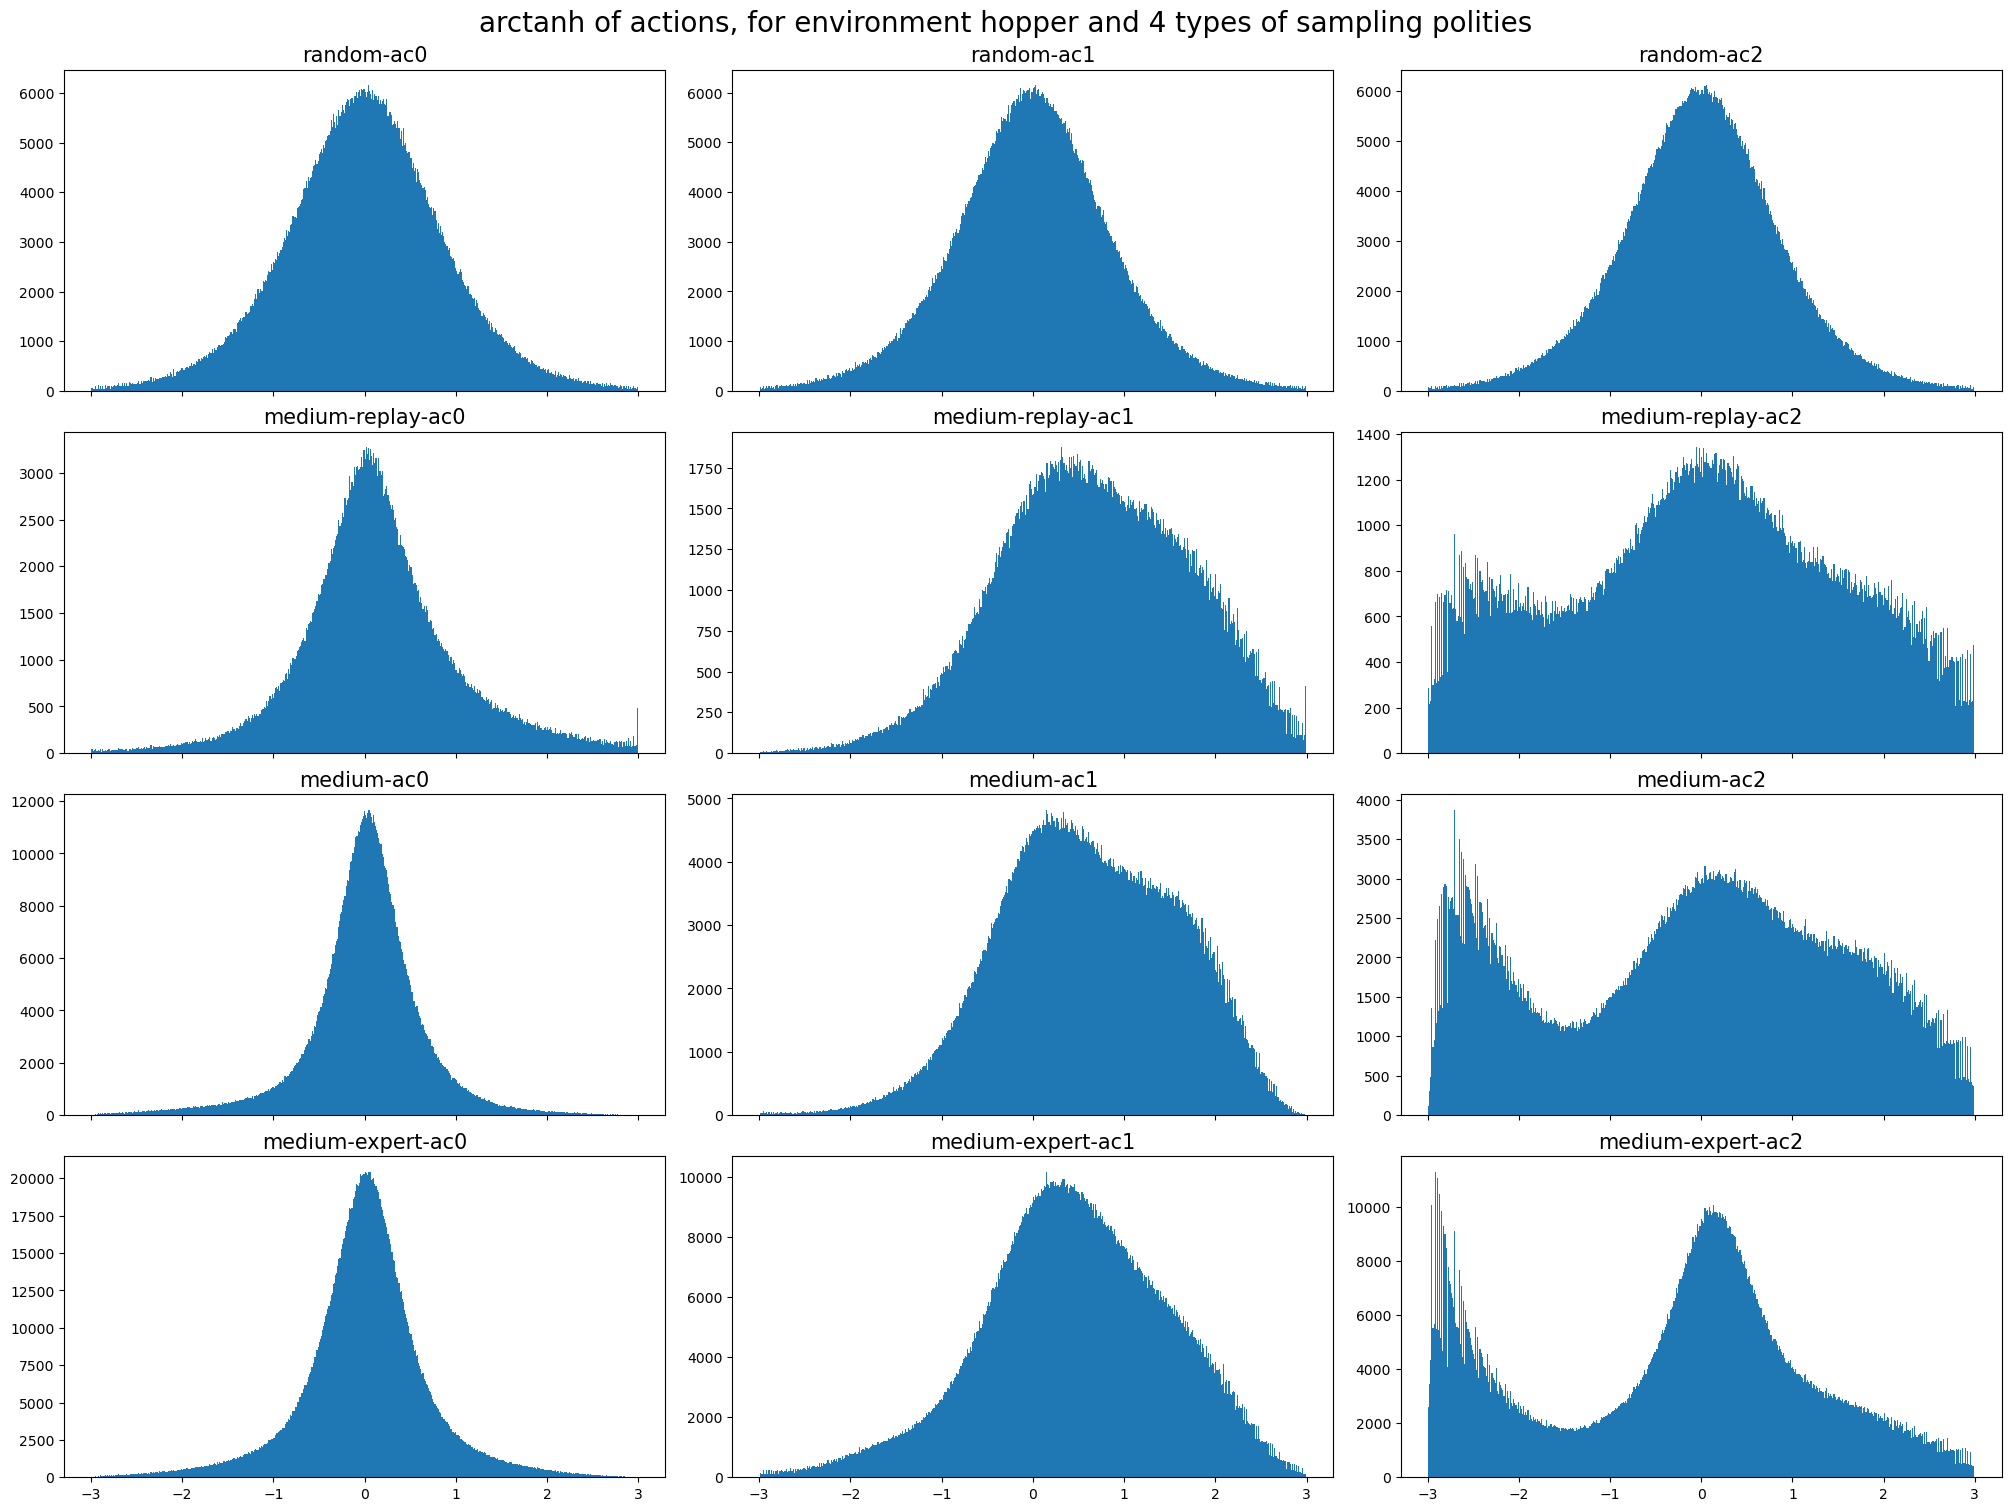

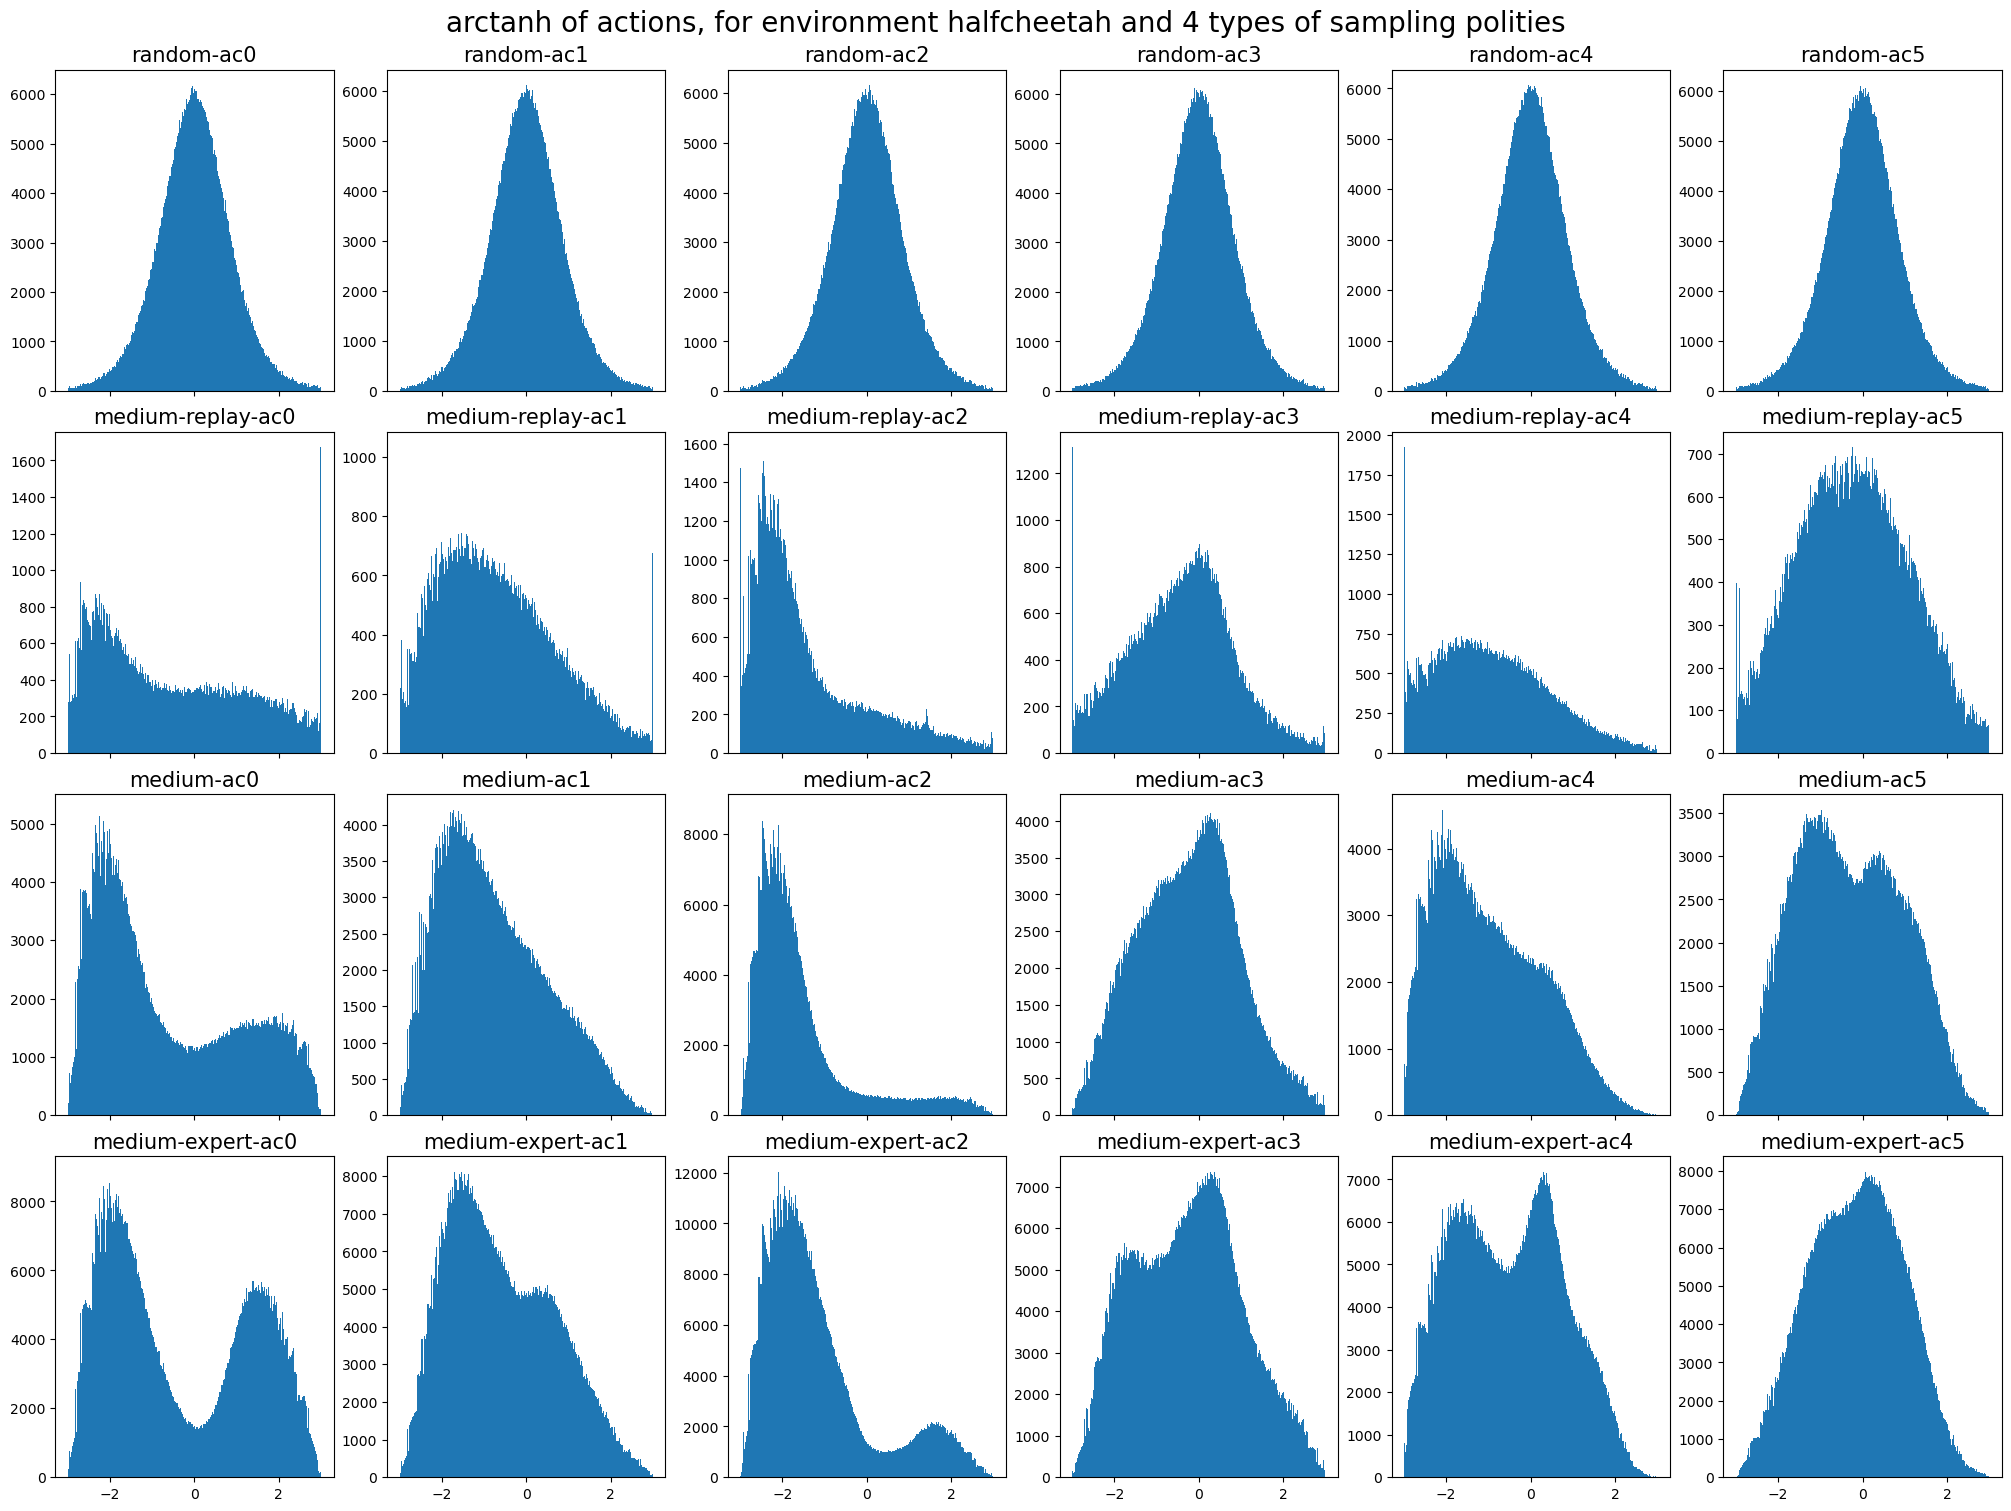

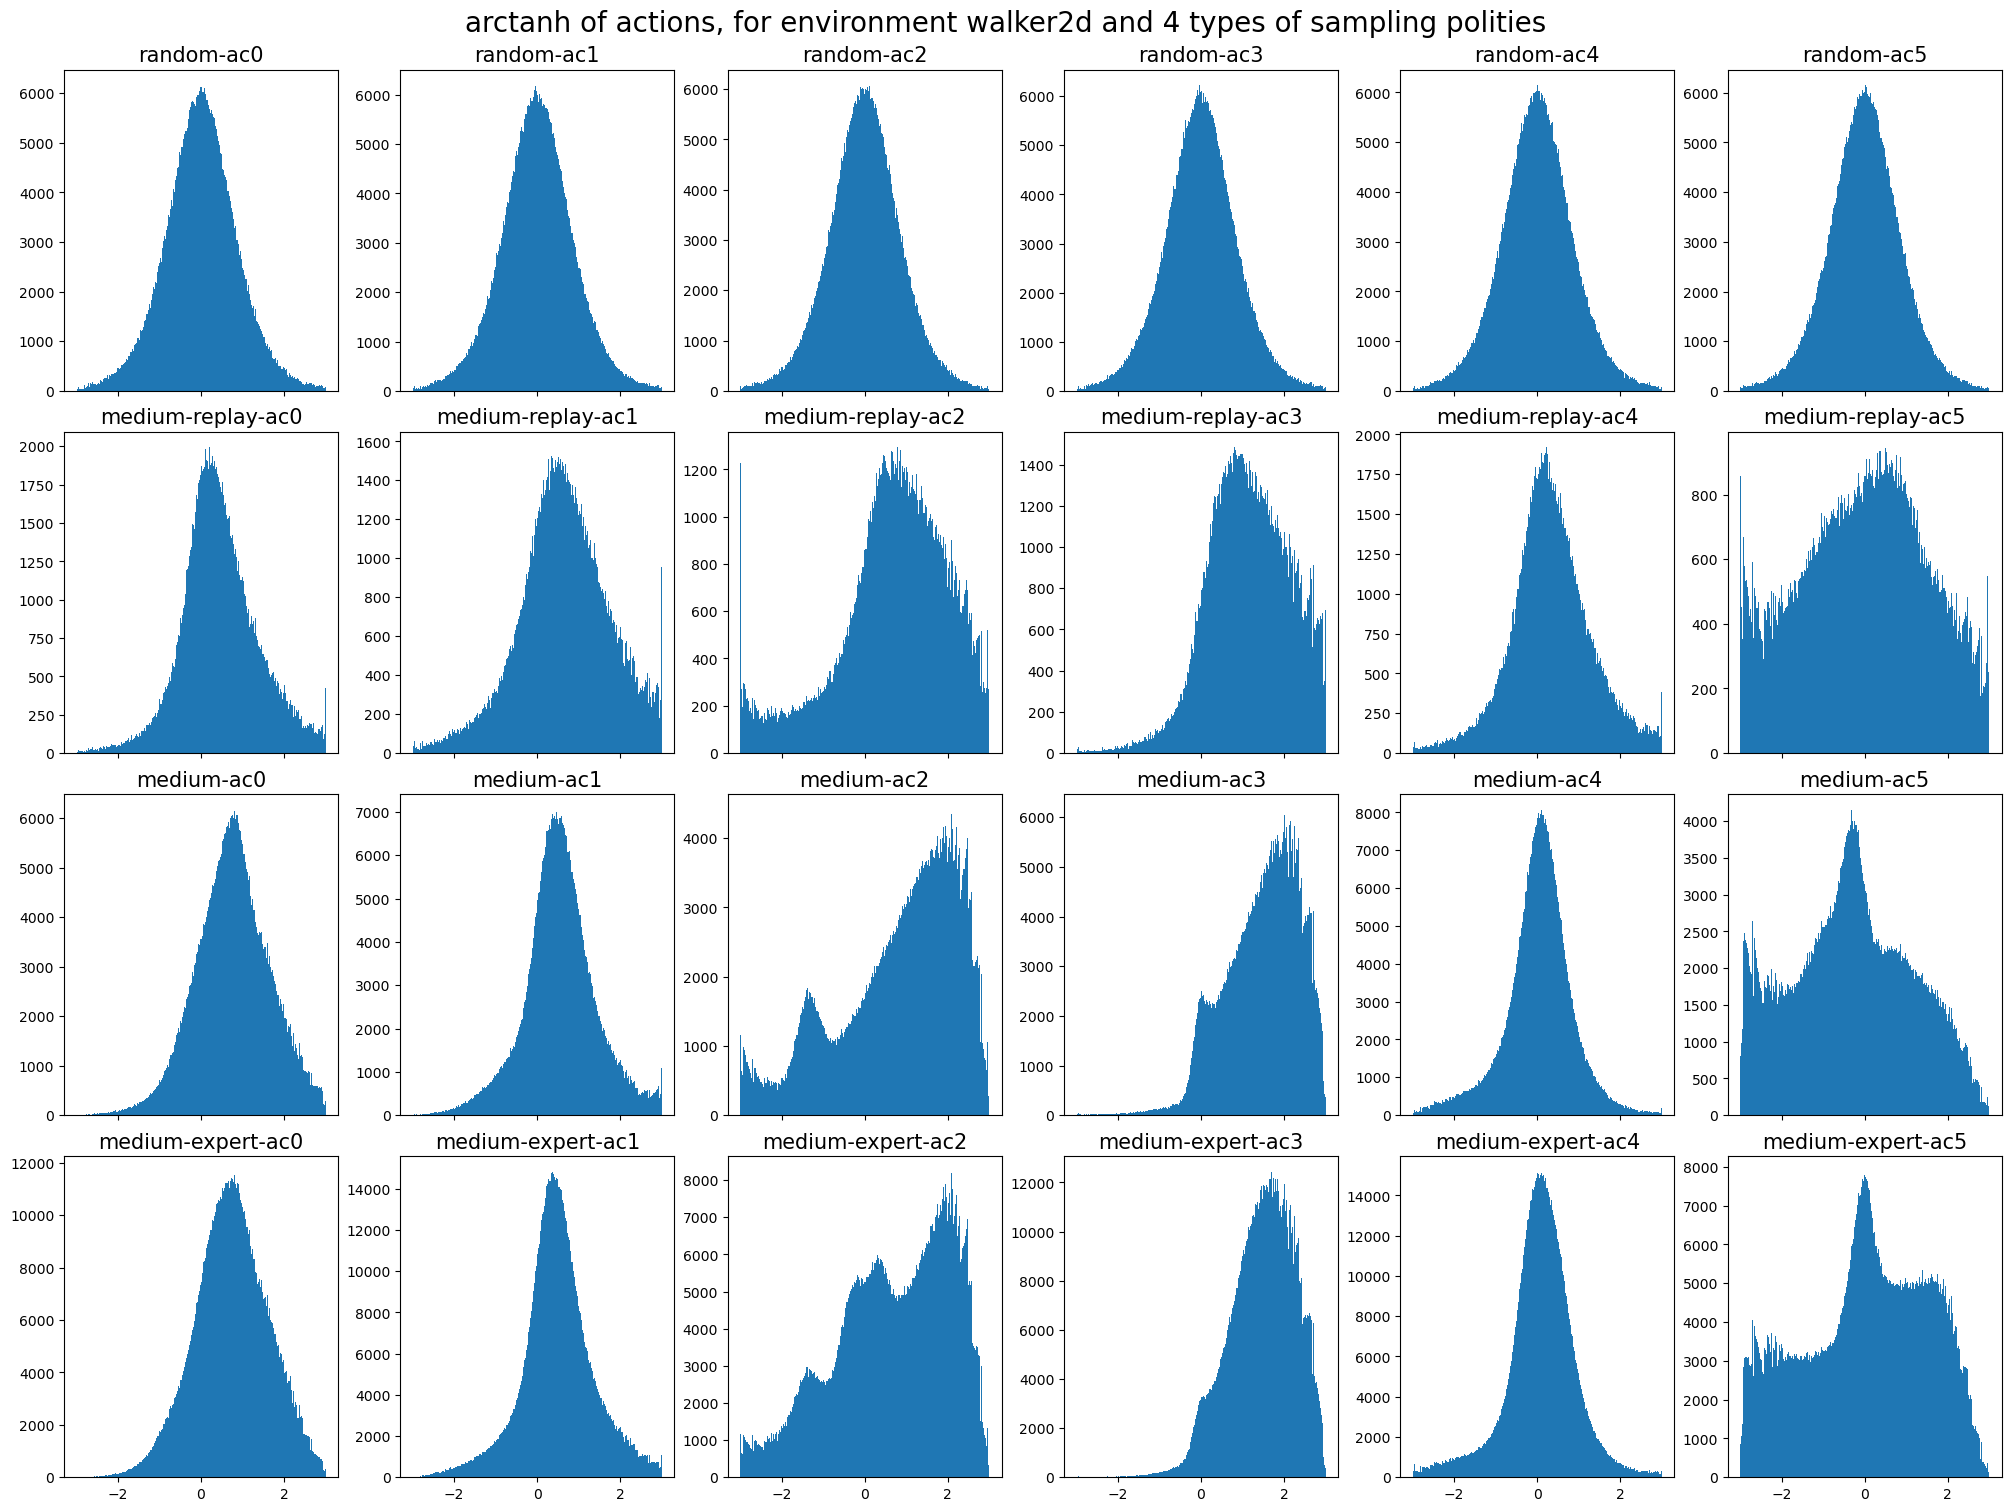

In [24]:
env_names = ['hopper', 'halfcheetah', 'walker2d']
policy_names = ['random', 'medium-replay', 'medium', 'medium-expert']

for env_name in env_names:
    labels = [x for x in dataset_dict['{e}-{p}-v2'.format(e=env_name, p="random")].keys() if 'ac' in x]  # which columns to predict based on the others
    fig, axs = plt.subplots(len(policy_names), len(labels), 
                            figsize=(20,15), sharex='col',
                            layout="constrained")

    for i, policy_name in enumerate(policy_names):
        for j, label in enumerate(labels):
            dataset = dataset_dict['{e}-{p}-v2'.format(e=env_name, p=policy_name)]
            
            axs[i, j].hist(data_preprocessor(dataset[[label]]), bins=500)
            axs[i, j].set_title('{p}-{l}'.format(p=policy_name, l=label), fontsize=15)

    fig.suptitle("arctanh of actions, for environment {e} and 4 types of sampling polities".format(e=env_name), fontsize=20)
    # fig.show()
    fig.savefig('arctanh actions {e}.png'.format(e=env_name))

In [45]:
env_name='halfcheetah-medium-expert-v2'
predictor = MultilabelPredictor.load('agModels/{env}-best_quality/'.format(env=env_name))
predictor

In [46]:
print(predictor.labels)
print(predictor.path)
print(predictor.consider_labels_correlation)
print(predictor.eval_metrics)
print(predictor.predictors['ac0']) # a string of filename

['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']
agModels/halfcheetah-medium-expert-v2-best_quality/
True
{'ac0': 'mean_squared_error', 'ac1': 'mean_squared_error', 'ac2': 'mean_squared_error', 'ac3': 'mean_squared_error', 'ac4': 'mean_squared_error', 'ac5': 'mean_squared_error'}
agModels/halfcheetah-medium-expert-v2-best_quality/Predictor_ac0/


In [74]:
test_data = data_preprocessor(dataset_dict[env_name])

In [50]:
print(test_data.shape)
print(type(test_data))

(2000000, 24)
<class 'autogluon.core.dataset.TabularDataset'>


In [98]:
%%time
real_acs = {}
pred_acs = {}

for predictor_quality in ['medium', 'good', 'high', 'best']:
    env_name='halfcheetah-medium-expert-v2'
    predictor = MultilabelPredictor.load('agModels/{env}-{quality}_quality/'.format(env=env_name, quality=predictor_quality))
    
    test_data = data_preprocessor(dataset_dict[env_name])
    test_data = test_data.sample(n=int(test_data.shape[0]/10), random_state=0)
    ob_r_labels = [x for x in test_data.keys() if 'ob' in x]
    ac_labels = [x for x in test_data.keys() if 'ac' in x]
    ob_r_labels.append('rtg')
    real_acs[predictor_quality] = test_data
    pred_acs[predictor_quality] = predictor.predict(test_data[ob_r_labels])

Predicting with TabularPredictor for label: ac0 ...
Predicting with TabularPredictor for label: ac1 ...
Predicting with TabularPredictor for label: ac2 ...
Predicting with TabularPredictor for label: ac3 ...
Predicting with TabularPredictor for label: ac4 ...
Predicting with TabularPredictor for label: ac5 ...
Predicting with TabularPredictor for label: ac0 ...
Predicting with TabularPredictor for label: ac1 ...
Predicting with TabularPredictor for label: ac2 ...
Predicting with TabularPredictor for label: ac3 ...
Predicting with TabularPredictor for label: ac4 ...
Predicting with TabularPredictor for label: ac5 ...
Predicting with TabularPredictor for label: ac0 ...
Predicting with TabularPredictor for label: ac1 ...
Predicting with TabularPredictor for label: ac2 ...
Predicting with TabularPredictor for label: ac3 ...
Predicting with TabularPredictor for label: ac4 ...
Predicting with TabularPredictor for label: ac5 ...
Predicting with TabularPredictor for label: ac0 ...
Predicting w

<timed exec>:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 3.38 s, sys: 79.9 ms, total: 3.46 s
Wall time: 2.34 s


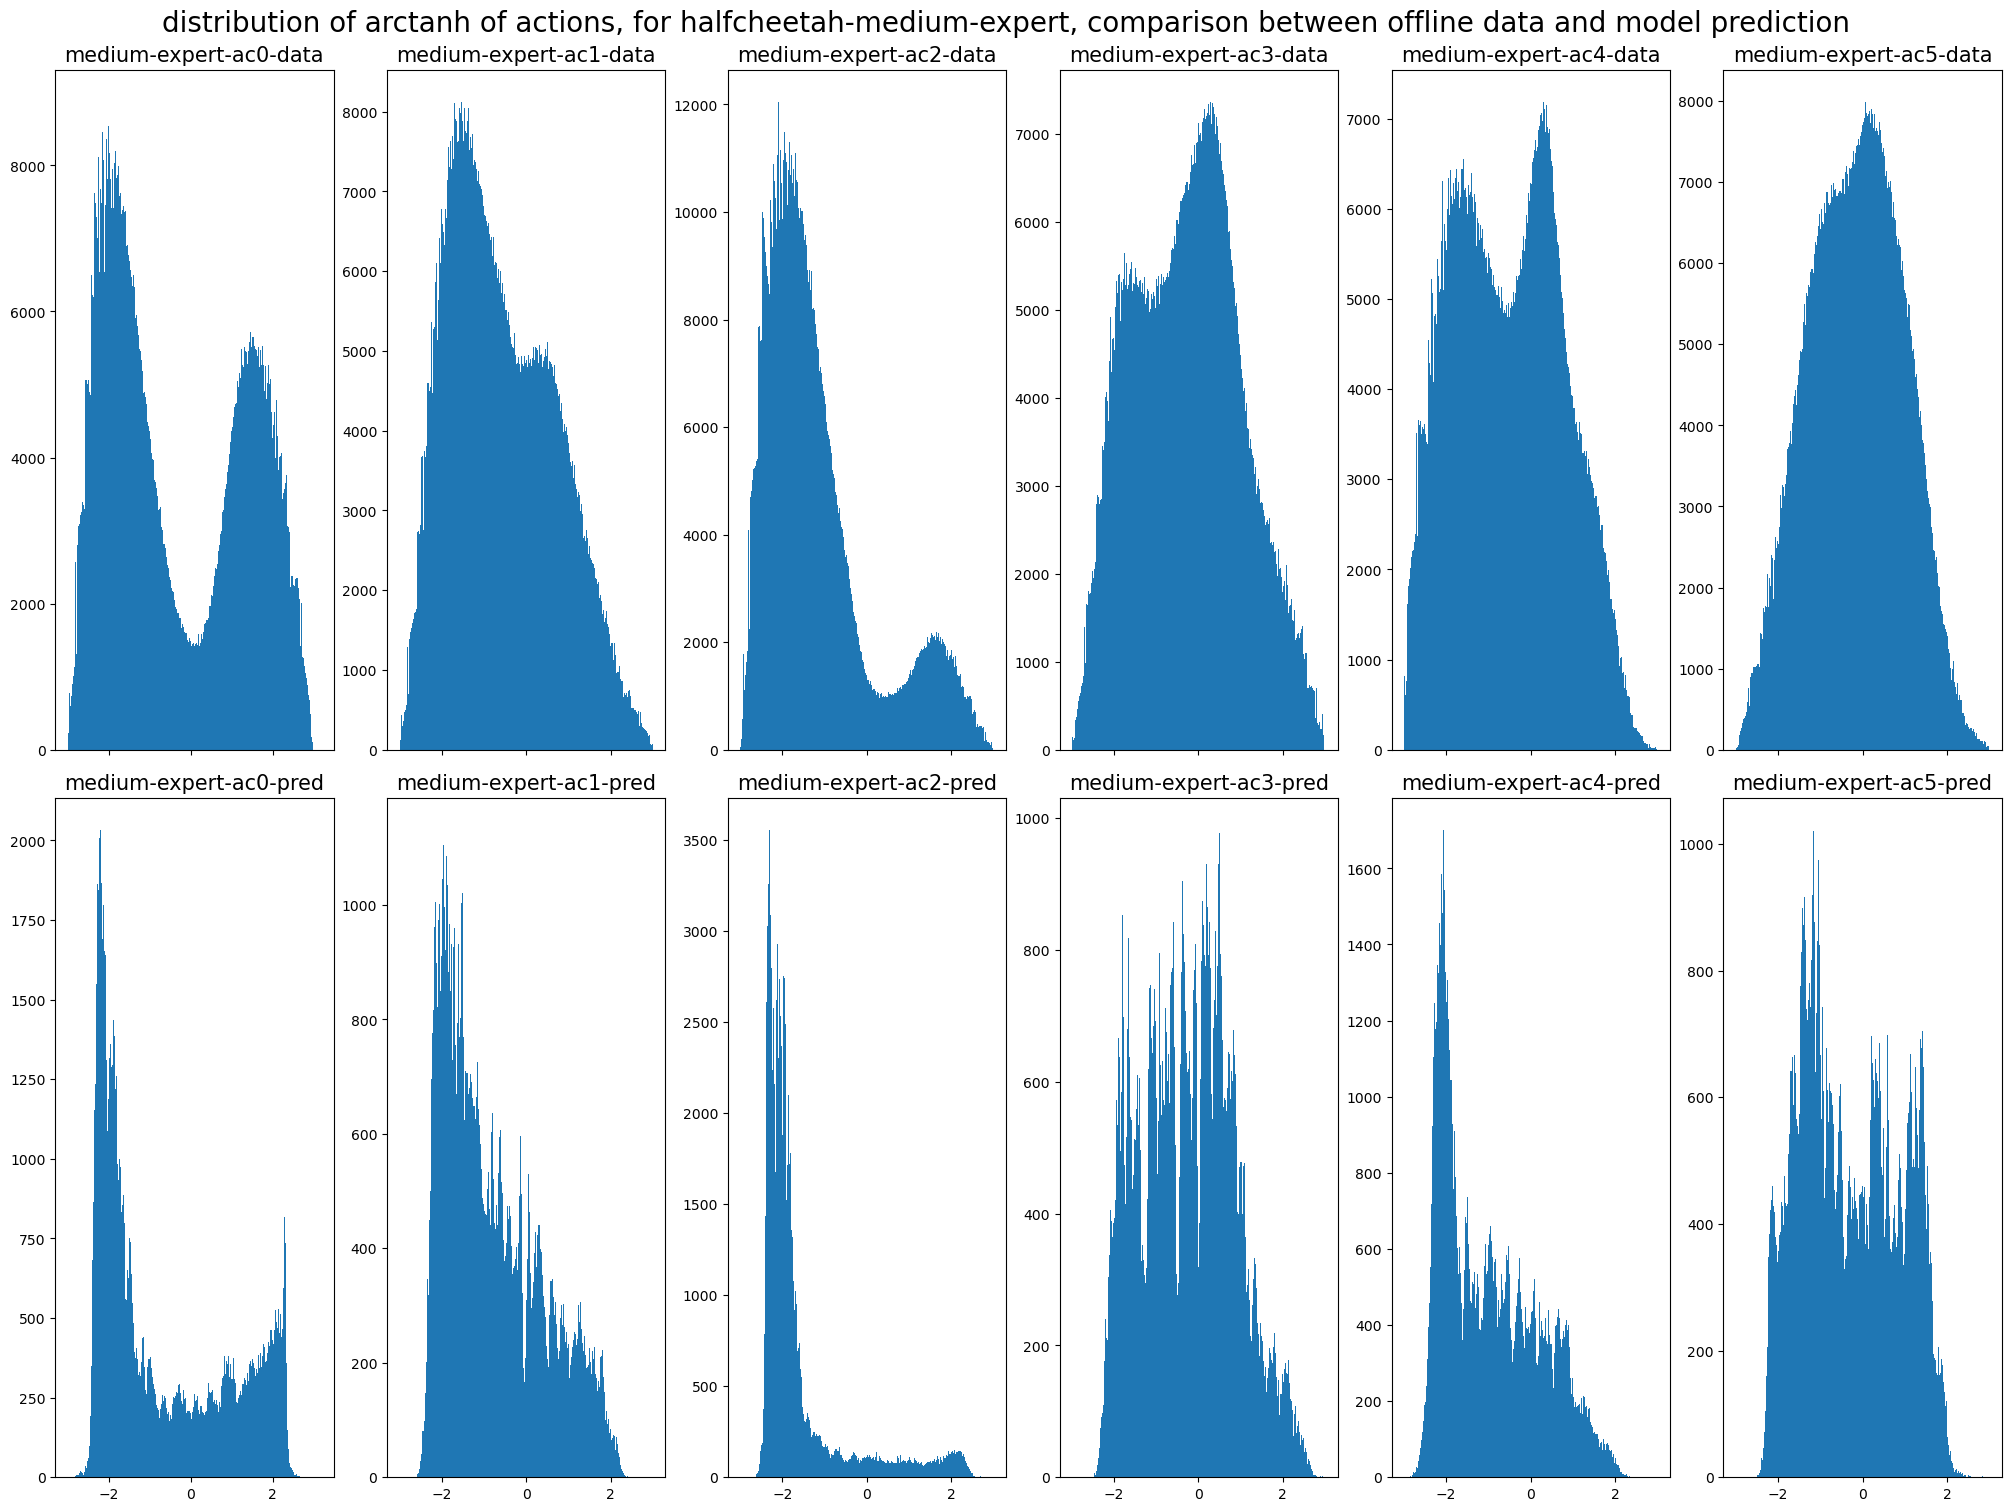

In [95]:
%%time
env_name = 'halfcheetah'
policy_names = ['medium-expert', 'medium-expert']
labels = [x for x in dataset_dict['{e}-{p}-v2'.format(e=env_name, p="random")].keys() if 'ac' in x]  # which columns to predict based on the others
fig, axs = plt.subplots(len(policy_names), len(labels), 
                        figsize=(20,15), sharex='col',
                        layout="constrained")

for i in range(2):
    for j, label in enumerate(labels):
        dataset = dataset_dict['{e}-{p}-v2'.format(e=env_name, p=policy_name)]
        if i == 0:
            axs[i, j].hist(data_preprocessor(dataset[[label]]), bins=500)
            axs[i, j].set_title('{p}-{l}-data'.format(p=policy_name, l=label), fontsize=15)
        if i == 1:
            axs[i, j].hist(pred_acs[[label]], bins=500)
            axs[i, j].set_title('{p}-{l}-pred'.format(p=policy_name, l=label), fontsize=15)

fig.suptitle("distribution of arctanh of actions, for {e}-{p}, comparison between offline data and model prediction".format(e=env_name, p='medium-expert'), fontsize=20)
fig.show()

Automatic pdb calling has been turned ON


/tmp/ipykernel_375/195373627.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


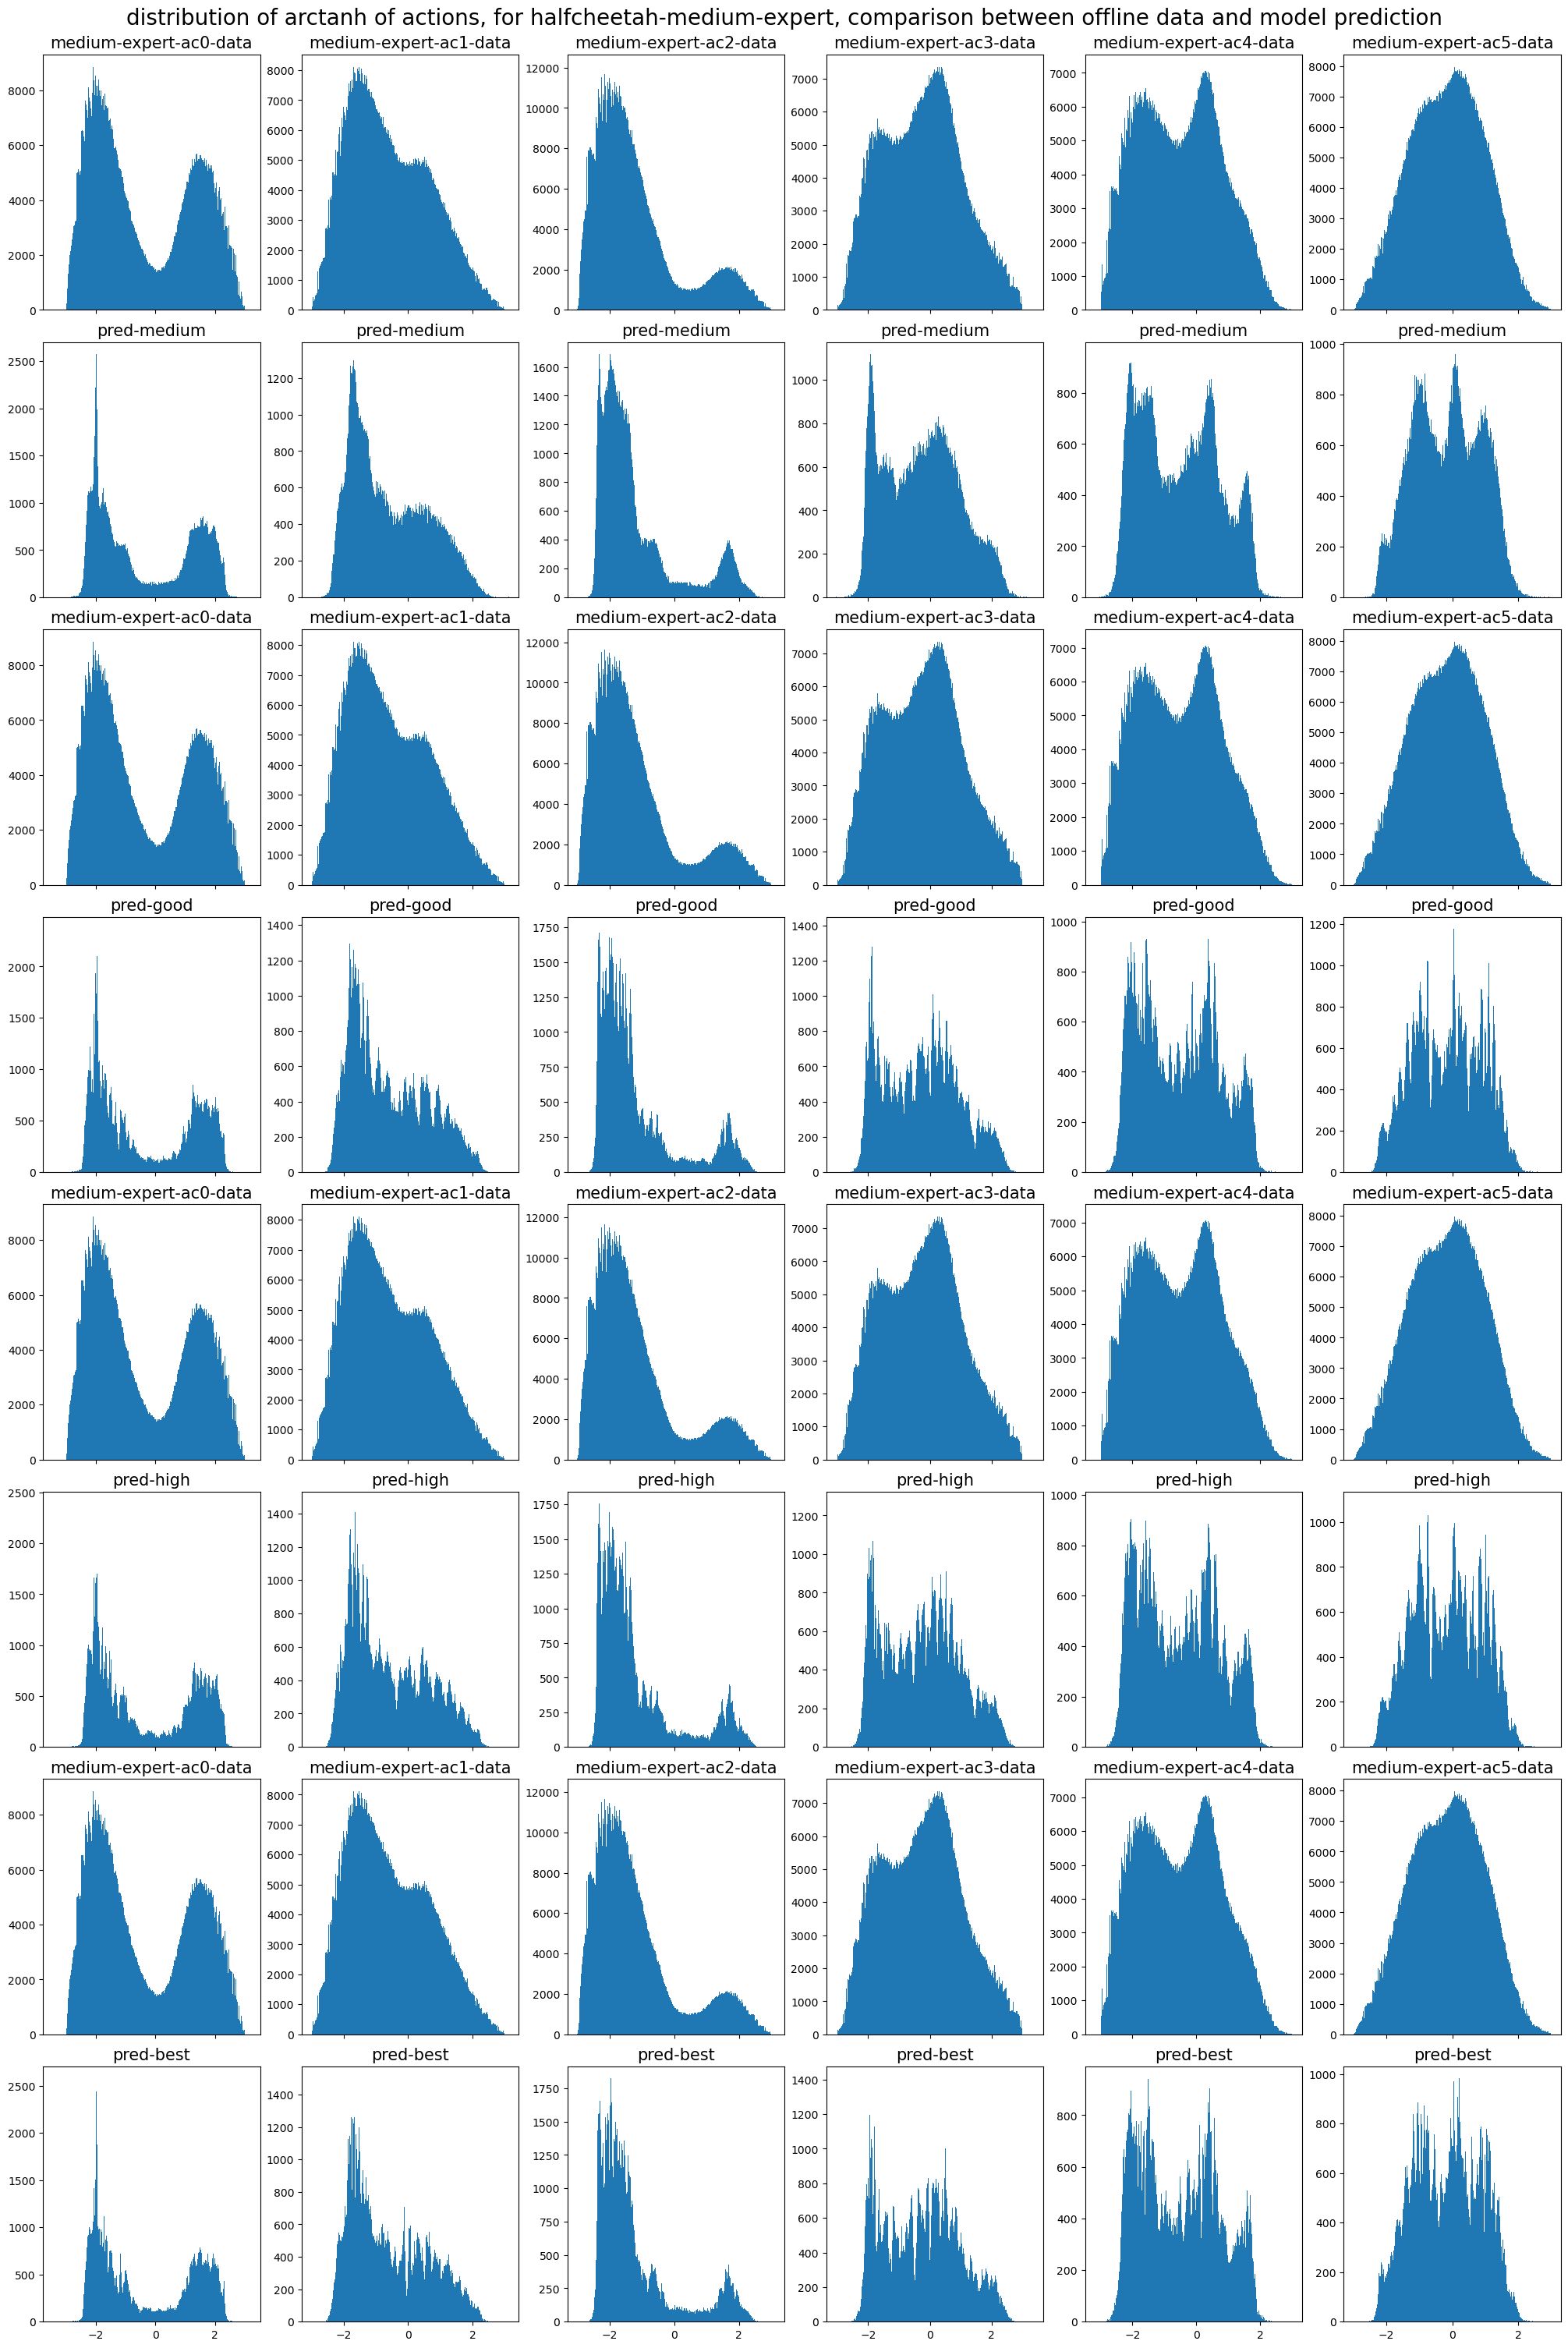

In [106]:
%pdb on
env_name = 'halfcheetah'
policy_names = 'medium-expert'
labels = [x for x in dataset_dict['{e}-{p}-v2'.format(e=env_name, p="random")].keys() if 'ac' in x]  # which columns to predict based on the others
fig, axs = plt.subplots(5, len(labels), 
                        figsize=(20,30), sharex='col',
                        layout="constrained")
for i, predictor_quality in enumerate(['medium', 'good', 'high', 'best']):
    for j, label in enumerate(labels):
        for k in range(2):
            dataset = dataset_dict['{e}-{p}-v2'.format(e=env_name, p=policy_name)]
            if k == 0:
                axs[2*i+k, j].hist(data_preprocessor(dataset[[label]]), bins=500)
                axs[2*i+k, j].set_title('{p}-{l}-data'.format(p=policy_name, l=label), fontsize=15)
            if k == 1:
                axs[2*i+k, j].hist(pred_acs[predictor_quality][[label]], bins=500)
                axs[2*i+k, j].set_title('pred-{q}'.format(p=policy_name, l=label, q=predictor_quality), fontsize=15)

fig.suptitle("distribution of arctanh of actions, for {e}-{p}, comparison between offline data and model prediction".format(e=env_name, p='medium-expert'), fontsize=20)
fig.show()

Automatic pdb calling has been turned ON


/tmp/ipykernel_375/826537915.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


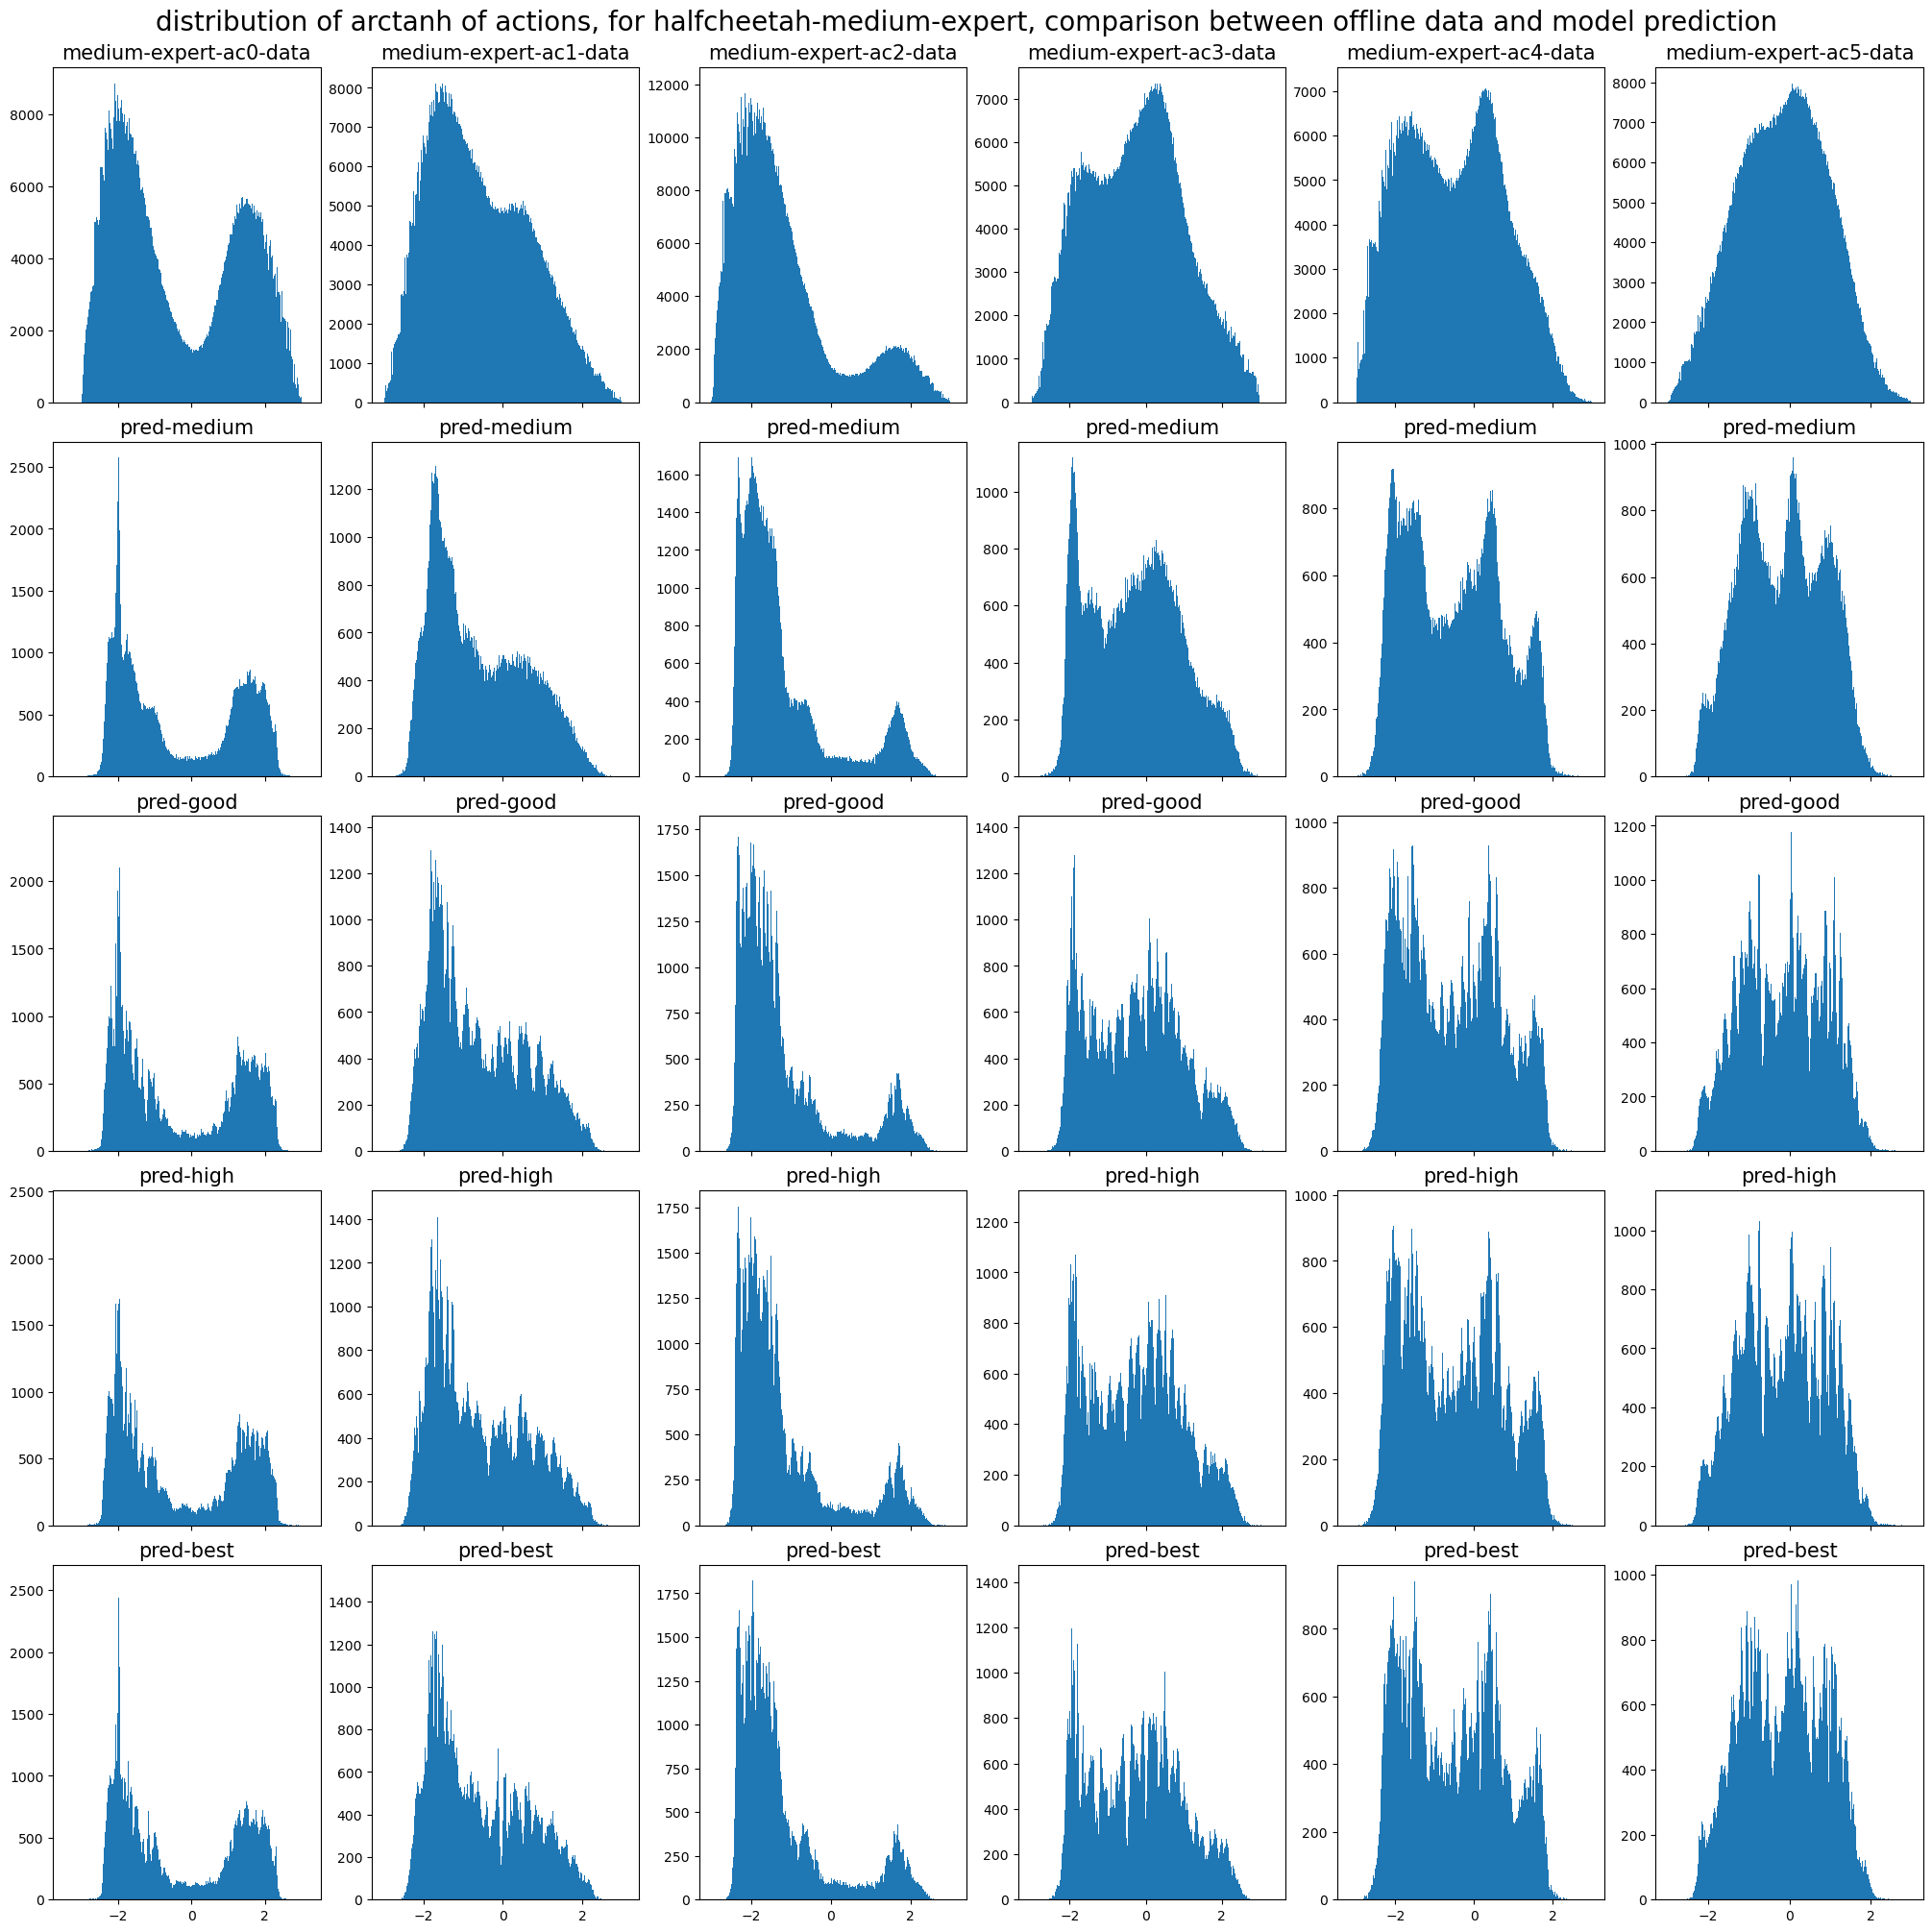

In [110]:
%pdb on
env_name = 'halfcheetah'
policy_names = 'medium-expert'
labels = [x for x in dataset_dict['{e}-{p}-v2'.format(e=env_name, p="random")].keys() if 'ac' in x]  # which columns to predict based on the others
fig, axs = plt.subplots(5, len(labels), 
                        figsize=(20,20), sharex='col',
                        layout="constrained")

for j, label in enumerate(labels):
    axs[0, j].hist(data_preprocessor(dataset[[label]]), bins=500)
    axs[0, j].set_title('{p}-{l}-data'.format(p=policy_name, l=label), fontsize=15)

for i, predictor_quality in enumerate(['medium', 'good', 'high', 'best']):
    for j, label in enumerate(labels):
        dataset = dataset_dict['{e}-{p}-v2'.format(e=env_name, p=policy_name)]
        axs[i+1, j].hist(pred_acs[predictor_quality][[label]], bins=500)
        axs[i+1, j].set_title('pred-{q}'.format(p=policy_name, l=label, q=predictor_quality), fontsize=15)

fig.suptitle("distribution of arctanh of actions, for {e}-{p}, comparison between offline data and model prediction".format(e=env_name, p='medium-expert'), fontsize=20)
fig.show()
fig.savefig("halfcheetah-medium-expert-predictions.png")

In [150]:
%pdb on
env_name = 'halfcheetah'
policy_names = 'medium-expert'
labels = [x for x in dataset_dict['{e}-{p}-v2'.format(e=env_name, p="random")].keys() if 'ac' in x]  # which columns to predict based on the others

table = [[" "] + labels]
for i, predictor_quality in enumerate(['medium', 'good', 'high', 'best']):
    table.append([predictor_quality])
    for j, label in enumerate(labels):
        dataset = dataset_dict['{e}-{p}-v2'.format(e=env_name, p=policy_name)]
        deltas = real_acs[predictor_quality][[label]] - pred_acs[predictor_quality][[label]]
        l2loss = (deltas**2).mean().mean()
        table[-1].append(l2loss)

Automatic pdb calling has been turned ON


In [151]:
import tabulate
from tabulate import tabulate
print(tabulate(table, headers="firstrow", tablefmt="github"))

|        |      ac0 |      ac1 |      ac2 |      ac3 |      ac4 |      ac5 |
|--------|----------|----------|----------|----------|----------|----------|
| medium | 0.203319 | 0.174317 | 0.201113 | 0.152283 | 0.163099 | 0.189098 |
| good   | 0.220616 | 0.188009 | 0.213779 | 0.167066 | 0.177785 | 0.201476 |
| high   | 0.219693 | 0.187197 | 0.214508 | 0.167088 | 0.177537 | 0.201598 |
| best   | 0.21679  | 0.184454 | 0.210596 | 0.16318  | 0.174045 | 0.199378 |
